# P9 - Préparation, nettoyage et analyse exploratoire

## Import des librairies

In [1]:
# import des librairies

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


## Création des fonctions 

In [2]:
# Fonction permettant de vérifier la qualité de la donnée d'un dataframe

def description(fichier):

    ## affiche le nombre de lignes et de variables dans le dataframe
    print("data shape :", fichier.shape,'\n')
      
    ## liste les variables et indique le type de valeurs qu'elles contiennent
    print(fichier.dtypes, '\n')
    
    ## décrit le contenu des variables et indique le nombre de valeurs,les quartiles, min, max, moy, median
    print(fichier.describe(), '\n')
    
    ## calcul le nombre de nan pour chaque variable et affiche celles qui en ont au moins 1
    nb_na = fichier.isnull().sum()
    print("vérification nan :",'\n',nb_na[nb_na>0])

In [3]:
# création de la fonction permettant de générer un fichier csv depuis un dataframe

def export_excel(df,nom_fichier):
    df.to_csv(nom_fichier, index=True, encoding="latin-1")
    print('Le data_frame a été exporté au format excel.')
    

## Méthodologie de sourcing 

Pour mener à bien le projet d'internationalisation de notre activité de vente de volaille, nous avons utilisé des données open source issues des sites de la FAO (organe de l'ONU liée à l'alimentation) et de la Banque Mondiale, couvrant 5 grandes thématiques essentielles à l'analyse des marchés/pays : 

- Economie 
- Alimentation
- Politique 
- Sociodémographie 
- Légal

Nous avons retenu un total de 13 variables pertinentes en lien avec notre problématique: 

-Disponibilité alimentaire (Kcal/personne/jour) – Viande de volailles---------ALIMENTATION/ECONOMIE

-Exportations quantité – Viande de Volailles----------------------------------ALIMENTATION / ECONOMIE

-Importations quantité – Viande de Volailles----------------------------------ALIMENTATION / ECONOMIE

-Production – Viande de Volailles---------------------------------------------ALIMENTATION / ECONOMIE

-Disponibilité intérieure – Viande de Volailles (par habitant)----------------ALIMENTATION / ECONOMIE

-Production – Viande de Volailles (par habitant)------------------------------ALIMENTATION / ECONOMIE

-Stabilité politique 2021-----------------------------------------------------POLITIQUE

-IDE en US$-------------------------------------------------------------------POLITIQUE / ECONOMIE

-Croissance annuelle PIB US$ par habitant-------------------------------------ECONOMIE

-PIB US$ par habitant---------------------------------------------------------ECONOMIE

-Population 2021 en milliers--------------------------------------------------SOCIODEMOGRAPHIE

-Evol pop à 10 ans------------------------------------------------------------SOCIODEMOGRAPHIE

-Pop urbaine 2020-------------------------------------------------------------SOCIODEMOGRAPHIE

-Temps implantation business (j)----------------------------------------------POLITIQUE / LEGAL

## Import et retraitement - Disponibilité Alimentaire (tous produits)

In [4]:
# Chargement des data de dispo alimentaire

df_dispo_alimentaire = pd.read_csv("DisponibiliteAlimentaire_2020.csv", decimal=".", index_col=0).reset_index()
df_dispo_alimentaire.head(3)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit (FAO),Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5511,Production,2511,Blé et produits,2020,2020,Milliers de tonnes,5185.0,I,Valeur imputée
1,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2020,2020,Milliers de tonnes,2741.0,I,Valeur imputée
2,FBS,Bilans Alimentaires (2010-),2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2020,2020,Milliers de tonnes,496.0,I,Valeur imputée


In [5]:
# Filtre sur les colonnes utiles 

df_dispo_alimentaire = df_dispo_alimentaire.loc[:,['Zone','Élément','Produit','Année','Valeur']]
df_dispo_alimentaire.head()

,Zone,Élément,Produit,Année,Valeur
0,Afghanistan,Production,Blé et produits,2020,5185.0
1,Afghanistan,Importations - Quantité,Blé et produits,2020,2741.0
2,Afghanistan,Variation de stock,Blé et produits,2020,496.0
3,Afghanistan,Exportations - Quantité,Blé et produits,2020,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,2020,7429.0


In [6]:
# Groupby pour obtenir un total "tous produits"

df_dispo_total = df_dispo_alimentaire.groupby(['Zone','Élément']).sum()
df_dispo_total = df_dispo_total.drop(['Année'], axis=1).reset_index()

df_dispo_total.head(3)


,Zone,Élément,Valeur
0,Afghanistan,Aliments pour animaux,371.00
1,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2239.00
2,Afghanistan,Disponibilité alimentaire en quantité (kg/pers...,396.01


In [7]:
# Gestion du cas particulier Taïwan (déjà compris dans Chine) et corée du nord (implantation impossible)

df_dispo_total = df_dispo_total.loc[~df_dispo_total['Zone'].isin(["Chine, Taiwan Province de","République populaire démocratique de Corée"]),:]
df_dispo_total.head()

,Zone,Élément,Valeur
0,Afghanistan,Aliments pour animaux,371.00
1,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2239.00
2,Afghanistan,Disponibilité alimentaire en quantité (kg/pers...,396.01
3,Afghanistan,Disponibilité de matière grasse en quantité (g...,38.94
4,Afghanistan,Disponibilité de protéines en quantité (g/pers...,56.65


<div class="alert alert-warning" role="alert"><b>
Nous supprimons les lignes "Chine, Taiwan Province de" et "République populaire démocratique de Corée" pour lesquelles nous n'avons pas assez d'informations sur les variables que nous souhaitons conserver, et qui semblent peu pertinentes pour notre analyse (Taïwan étant déjà comprise dans "CHINE" et la Corée du Nord étant cloisonnée du reste du monde).
</div>

In [8]:
liste_colonnes_a_conserver_dispo = ['Disponibilité alimentaire (Kcal/personne/jour)','Disponibilité intérieure','Exportations - Quantité','Importations - Quantité','Production']
liste_colonnes_a_conserver_dispo

['Disponibilité alimentaire (Kcal/personne/jour)',
 'Disponibilité intérieure',
 'Exportations - Quantité',
 'Importations - Quantité',
 'Production']

In [9]:
df_dispo_total = df_dispo_total.loc[df_dispo_total['Élément'].isin(liste_colonnes_a_conserver_dispo)]
df_dispo_total

,Zone,Élément,Valeur
1,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),2239.00
5,Afghanistan,Disponibilité intérieure,18556.20
6,Afghanistan,Exportations - Quantité,884.00
7,Afghanistan,Importations - Quantité,5392.10
10,Afghanistan,Production,15077.10
...,...,...,...
2591,Îles Salomon,Disponibilité alimentaire (Kcal/personne/jour),2357.00
2595,Îles Salomon,Disponibilité intérieure,693.79
2596,Îles Salomon,Exportations - Quantité,99.27
2597,Îles Salomon,Importations - Quantité,101.01


In [10]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_dispo_total = df_dispo_total.pivot_table(index = 'Zone', columns = 'Élément', values = 'Valeur')
df_dispo_total.head(3)

Élément,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
Zone,,,,,
Afghanistan,2239.0,18556.20,884.00,5392.10,15077.10
Afrique du Sud,2855.0,62506.02,12555.12,8279.13,69092.04
Albanie,3302.0,4863.07,188.02,850.40,4252.70


In [11]:
# Renommage des colonnes pour y ajouter la notion "tous produits" en anticipation du merge avec les colonnes "Viande de Volailles"

df_dispo_total.rename(columns = {'Disponibilité alimentaire (Kcal/personne/jour)':'Disponibilité alimentaire (Kcal/personne/jour) - tous produits',
                                       'Disponibilité intérieure':'Disponibilité intérieure - tous produits',
                                       'Exportations - Quantité':'Exportations quantité - tous produits',
                                       'Importations - Quantité':'Importations quantité - tous produits',
                                       'Production':'Production - tous produits'}, inplace = True)
df_dispo_total.head(3)

Élément,Disponibilité alimentaire (Kcal/personne/jour) - tous produits,Disponibilité intérieure - tous produits,Exportations quantité - tous produits,Importations quantité - tous produits,Production - tous produits
Zone,,,,,
Afghanistan,2239.0,18556.20,884.00,5392.10,15077.10
Afrique du Sud,2855.0,62506.02,12555.12,8279.13,69092.04
Albanie,3302.0,4863.07,188.02,850.40,4252.70


In [12]:
# Analyse du dataframe df_dispo_volaille

description(df_dispo_total)

data shape : (184, 5) 

Élément
Disponibilité alimentaire (Kcal/personne/jour) - tous produits    float64
Disponibilité intérieure - tous produits                          float64
Exportations quantité - tous produits                             float64
Importations quantité - tous produits                             float64
Production - tous produits                                        float64
dtype: object 

Élément  Disponibilité alimentaire (Kcal/personne/jour) - tous produits  \
count                                           184.000000                
mean                                           2917.065217                
std                                             462.638484                
min                                            1745.000000                
25%                                            2600.000000                
50%                                            2917.000000                
75%                                            3317.75000

## Import et retraitement - Disponibilité Alimentaire (Volailles)

In [13]:
# Filtre sur le produit "viande de volailles" 

df_dispo_volaille = df_dispo_alimentaire.loc[df_dispo_alimentaire['Produit'] == 'Viande de Volailles']
df_dispo_volaille.head(3)

,Zone,Élément,Produit,Année,Valeur
732,Afghanistan,Production,Viande de Volailles,2020,28.0
733,Afghanistan,Importations - Quantité,Viande de Volailles,2020,36.0
734,Afghanistan,Variation de stock,Viande de Volailles,2020,-2.0


In [14]:
# Gestion du cas particulier Taïwan (déjà compris dans Chine) et corée du nord (implantation impossible)

df_dispo_volaille = df_dispo_volaille.loc[~df_dispo_volaille['Zone'].isin(["Chine, Taiwan Province de","République populaire démocratique de Corée"]),:]
df_dispo_volaille

,Zone,Élément,Produit,Année,Valeur
732,Afghanistan,Production,Viande de Volailles,2020,28.00
733,Afghanistan,Importations - Quantité,Viande de Volailles,2020,36.00
734,Afghanistan,Variation de stock,Viande de Volailles,2020,-2.00
735,Afghanistan,Exportations - Quantité,Viande de Volailles,2020,0.00
736,Afghanistan,Disponibilité intérieure,Viande de Volailles,2020,67.00
...,...,...,...,...,...
179150,Zimbabwe,Nourriture,Viande de Volailles,2020,69.00
179151,Zimbabwe,Disponibilité alimentaire en quantité (kg/pers...,Viande de Volailles,2020,4.62
179152,Zimbabwe,Disponibilité alimentaire (Kcal/personne/jour),Viande de Volailles,2020,15.00
179153,Zimbabwe,Disponibilité de protéines en quantité (g/pers...,Viande de Volailles,2020,1.56


In [15]:
df_dispo_volaille = df_dispo_volaille.loc[df_dispo_volaille['Élément'].isin(liste_colonnes_a_conserver_dispo)]
df_dispo_volaille

,Zone,Élément,Produit,Année,Valeur
732,Afghanistan,Production,Viande de Volailles,2020,28.0
733,Afghanistan,Importations - Quantité,Viande de Volailles,2020,36.0
735,Afghanistan,Exportations - Quantité,Viande de Volailles,2020,0.0
736,Afghanistan,Disponibilité intérieure,Viande de Volailles,2020,67.0
740,Afghanistan,Disponibilité alimentaire (Kcal/personne/jour),Viande de Volailles,2020,6.0
...,...,...,...,...,...
178137,Zambie,Disponibilité alimentaire (Kcal/personne/jour),Viande de Volailles,2020,9.0
179145,Zimbabwe,Production,Viande de Volailles,2020,67.0
179146,Zimbabwe,Importations - Quantité,Viande de Volailles,2020,1.0
179148,Zimbabwe,Disponibilité intérieure,Viande de Volailles,2020,69.0


In [16]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_dispo_volaille = df_dispo_volaille.pivot_table(index = 'Zone', columns = 'Élément', values = 'Valeur')
df_dispo_volaille.head(3)

Élément,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
Zone,,,,,
Afghanistan,6.0,67.0,0.0,36.0,28.0
Afrique du Sud,140.0,2067.0,49.0,425.0,1881.0
Albanie,71.0,40.0,NaN,26.0,14.0


In [17]:
# Renommage des colonnes pour y ajouter la notion "tous produits" en anticipation du merge avec les colonnes "Tous produits"
df_dispo_volaille.rename(columns = {'Disponibilité alimentaire (Kcal/personne/jour)':'Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles',
                                       'Disponibilité intérieure':'Disponibilité intérieure - Viande de Volailles',
                                       'Exportations - Quantité':'Exportations quantité - Viande de Volailles',
                                       'Importations - Quantité':'Importations quantité - Viande de Volailles',
                                       'Production':'Production - Viande de Volailles'}, inplace = True)
df_dispo_volaille.head(3)

Élément,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Disponibilité intérieure - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles
Zone,,,,,
Afghanistan,6.0,67.0,0.0,36.0,28.0
Afrique du Sud,140.0,2067.0,49.0,425.0,1881.0
Albanie,71.0,40.0,NaN,26.0,14.0


In [18]:
# Analyse du dataframe df_dispo_volaille

description(df_dispo_volaille)

data shape : (184, 5) 

Élément
Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles    float64
Disponibilité intérieure - Viande de Volailles                          float64
Exportations quantité - Viande de Volailles                             float64
Importations quantité - Viande de Volailles                             float64
Production - Viande de Volailles                                        float64
dtype: object 

Élément  Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles  \
count                                           184.000000                      
mean                                             81.119565                      
std                                              64.477360                      
min                                               2.000000                      
25%                                              25.000000                      
50%                                              69.000000        

In [19]:
# Affichage des NAN detectés dans le df_dispo_volaille pour la variable "Production"

check_nan = df_dispo_volaille[df_dispo_volaille['Production - Viande de Volailles'].isnull()]
check_nan

Élément,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Disponibilité intérieure - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles
Zone,,,,,
Djibouti,12.0,4.0,NaN,4.0,NaN
Maldives,38.0,11.0,0.0,11.0,NaN


In [20]:
# Retraitement des NAN (remplacement par des valeurs '0')

df_dispo_volaille['Production - Viande de Volailles'] = df_dispo_volaille['Production - Viande de Volailles'].fillna(0)
df_dispo_volaille['Exportations quantité - Viande de Volailles'] = df_dispo_volaille['Exportations quantité - Viande de Volailles'].fillna(0)

<div class="alert alert-warning">
<b> La "disponibilité intérieure" étant un calcul correspondant à la somme des importations, de la production et déduisant l'exportation, il est possible de déduire la valeur 0 pour les NAN dans les pays où l'importation est égale à la disponbilité. Nous avons donc procédé à ce remplacement.
 </div>

In [21]:
# Analyse du dataframe df_dispo_volaille après modification

description(df_dispo_volaille)

data shape : (184, 5) 

Élément
Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles    float64
Disponibilité intérieure - Viande de Volailles                          float64
Exportations quantité - Viande de Volailles                             float64
Importations quantité - Viande de Volailles                             float64
Production - Viande de Volailles                                        float64
dtype: object 

Élément  Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles  \
count                                           184.000000                      
mean                                             81.119565                      
std                                              64.477360                      
min                                               2.000000                      
25%                                              25.000000                      
50%                                              69.000000        

## Import et retraitement - Population

In [22]:
# Chargement des data de population (2000-2021)

df_population = pd.read_csv("Population2000_2021.csv", decimal=".", index_col=0).reset_index()
df_population.head(3)

,Code Domaine,Domaine,Code zone (FAO),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,19542.982,X,Ciffre de sources internationales,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,19688.632,X,Ciffre de sources internationales,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,21000.256,X,Ciffre de sources internationales,NaN


In [23]:
# Filtre sur les colonnes utiles 

df_population = df_population.loc[:,['Zone','Année','Valeur']]
df_population.head(3)

,Zone,Année,Valeur
0,Afghanistan,2000,19542.982
1,Afghanistan,2001,19688.632
2,Afghanistan,2002,21000.256


In [24]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_population = df_population.pivot_table(index = 'Zone', columns = 'Année', values = 'Valeur')
df_population.head(3)

Année,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Zone,,,,,,,,,,,,,,,,,,,,,
Afghanistan,19542.982,19688.632,21000.256,22645.130,23553.551,24411.191,25442.944,25903.301,26427.199,27385.307,...,30466.479,31541.209,32716.210,33753.499,34636.207,35643.418,36686.784,37769.499,38972.230,40099.462
Afrique du Sud,46813.266,47229.714,47661.514,48104.048,48556.071,49017.147,49491.756,49996.094,50565.812,51170.779,...,53145.033,53873.616,54729.551,55876.504,56422.274,56641.209,57339.635,58087.055,58801.927,59392.255
Albanie,3182.021,3153.612,3123.551,3092.991,3062.622,3032.634,3003.387,2976.084,2951.689,2930.541,...,2892.193,2887.014,2884.102,2882.481,2881.063,2879.355,2877.013,2873.883,2866.849,2854.710


In [25]:
# Création indicateur d'évolution population vs vs An-10 (pour avoir à la fois une vision contextuelle et structurelle)

df_population['evol pop à 10 ans'] = (df_population[2021]-df_population[2012])/df_population[2012]*100
df_population.head(3)

Année,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,evol pop à 10 ans
Zone,,,,,,,,,,,,,,,,,,,,,
Afghanistan,19542.982,19688.632,21000.256,22645.130,23553.551,24411.191,25442.944,25903.301,26427.199,27385.307,...,31541.209,32716.210,33753.499,34636.207,35643.418,36686.784,37769.499,38972.230,40099.462,31.618301
Afrique du Sud,46813.266,47229.714,47661.514,48104.048,48556.071,49017.147,49491.756,49996.094,50565.812,51170.779,...,53873.616,54729.551,55876.504,56422.274,56641.209,57339.635,58087.055,58801.927,59392.255,11.755044
Albanie,3182.021,3153.612,3123.551,3092.991,3062.622,3032.634,3003.387,2976.084,2951.689,2930.541,...,2887.014,2884.102,2882.481,2881.063,2879.355,2877.013,2873.883,2866.849,2854.710,-1.296006


In [26]:
# Analyse du dataframe df_population

description(df_population)

data shape : (238, 23) 

Année
2000                 float64
2001                 float64
2002                 float64
2003                 float64
2004                 float64
2005                 float64
2006                 float64
2007                 float64
2008                 float64
2009                 float64
2010                 float64
2011                 float64
2012                 float64
2013                 float64
2014                 float64
2015                 float64
2016                 float64
2017                 float64
2018                 float64
2019                 float64
2020                 float64
2021                 float64
evol pop à 10 ans    float64
dtype: object 

Année          2000          2001          2002          2003          2004  \
count  2.290000e+02  2.290000e+02  2.290000e+02  2.290000e+02  2.290000e+02   
mean   3.249077e+04  3.288679e+04  3.327995e+04  3.367130e+04  3.406411e+04   
std    1.404898e+05  1.418839e+05  1.432405e+05  

In [27]:
# Filtre sur les colonnes pertinentes à l'analyse

df_population.rename(columns = {2021:'population 2021 en milliers'}, inplace = True)
df_population = df_population.loc[:,['population 2021 en milliers','evol pop à 10 ans']]
df_population.head(3)

Année,population 2021 en milliers,evol pop à 10 ans
Zone,,
Afghanistan,40099.462,31.618301
Afrique du Sud,59392.255,11.755044
Albanie,2854.710,-1.296006


## Import et retraitement - Stabilité Politique

In [28]:
# Chargement des data de stabilité politique (2000-2020)

df_stabilite_politique = pd.read_csv("StabilitePolitique2000_2020v2.csv", decimal=".", sep=";",index_col=0, encoding="latin-1").reset_index()
df_stabilite_politique.head(3)

,Domaine,Zone,Élément,Produit,Année,Valeur
0,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/ter...,2000,-2.44
1,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/ter...,2002,-2.04
2,Données de la sécurité alimentaire,Afghanistan,Valeur,Stabilité politique et absence de violence/ter...,2003,-2.20


In [29]:
# Filtre sur les colonnes utiles 

df_stabilite_politique = df_stabilite_politique.loc[:,['Zone','Année','Valeur']]
df_stabilite_politique.head(3)

,Zone,Année,Valeur
0,Afghanistan,2000,-2.44
1,Afghanistan,2002,-2.04
2,Afghanistan,2003,-2.20


In [30]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_stabilite_politique = df_stabilite_politique.pivot_table(index = 'Zone', columns = 'Année', values = 'Valeur')

In [31]:
# Filtre sur les colonnes pertinentes à l'analyse

df_stabilite_politique.rename(columns = {2020:'stabilite politique 2021'}, inplace = True)
df_stabilite_politique = df_stabilite_politique.loc[:,['stabilite politique 2021']]
df_stabilite_politique.head(3)

Année,stabilite politique 2021
Zone,
Afghanistan,-2.73
Afrique du Sud,-0.24
Albanie,0.08


In [32]:
# Analyse du dataframe df_stabilite_politique

description(df_stabilite_politique)

data shape : (203, 1) 

Année
stabilite politique 2021    float64
dtype: object 

Année  stabilite politique 2021
count                203.000000
mean                  -0.060936
std                    0.987221
min                   -2.730000
25%                   -0.635000
50%                    0.020000
75%                    0.765000
max                    1.910000 

vérification nan : 
 Series([], dtype: int64)


## Import et retraitement - Population Urbaine

In [33]:
# Chargement des data population rural / urbain

df_population_urbaine = pd.read_csv("PopRuralUrbain_2020.csv", decimal=".", index_col=0).reset_index()
df_population_urbaine.head(3)

,Domaine,Zone,Élément,Produit,Année,Unité,Valeur
0,Séries temporelles annuelles,Afghanistan,Population totale,Population-Estimations,2019,1000 personnes,37769.499
1,Séries temporelles annuelles,Afghanistan,Population rurale,Population-Estimations,2019,1000 personnes,27626.382
2,Séries temporelles annuelles,Afghanistan,Population urbaine,Population-Estimations,2019,1000 personnes,9582.625


In [34]:
# Filtre sur les colonnes utiles et sur l'année 2020

df_population_urbaine = df_population_urbaine.loc[:,['Zone','Élément','Année','Valeur']]
df_population_urbaine = df_population_urbaine.loc[df_population_urbaine['Élément'] != 'Population rurale',:]
df_population_urbaine = df_population_urbaine.loc[df_population_urbaine['Année'] == 2020]
df_population_urbaine.head(3)

,Zone,Élément,Année,Valeur
3,Afghanistan,Population totale,2020,38972.230
5,Afghanistan,Population urbaine,2020,9904.337
9,Afrique du Sud,Population totale,2020,58801.927


In [35]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_population_urbaine = df_population_urbaine.pivot_table(index = 'Zone', columns = 'Élément', values = 'Valeur')
df_population_urbaine.head(3)

Élément,Population totale,Population urbaine
Zone,,
Afghanistan,38972.230,9904.337
Afrique du Sud,58801.927,39550.889
Albanie,2866.849,1827.362


In [36]:
# Création des indicateurs % pop urbaine et % pop rurale pour l'année 2020 + rename colonnes pour ajouter l'année

df_population_urbaine['% pop urbaine 2020'] = df_population_urbaine['Population urbaine'] / df_population_urbaine['Population totale']
df_population_urbaine = df_population_urbaine.drop(columns=['Population totale', 'Population urbaine'])
df_population_urbaine

Élément,% pop urbaine 2020
Zone,
Afghanistan,0.254138
Afrique du Sud,0.672612
Albanie,0.637411
Algérie,0.735321
Allemagne,0.767204
...,...
Îles Salomon,0.231030
Îles Turques-et-Caïques,0.781236
Îles Vierges américaines,1.001563


## Import et retraitement - Investissements Directs Etrangers (IED / IDE)

<div class="alert alert-info" role="alert">
Définition "Investissements directs étrangers (IDE/IED)" :
    
    Investissement international qu’une entité sise dans une économie effectue dans le
    but d’obtenir un intérêt durable dans une entreprise sise dans une
    autre économie.
Source : FAO
</div>



In [37]:
# Chargement des data IDE

df_ide = pd.read_csv("InvestDirectEtranger_2020.csv", decimal=".", index_col=0).reset_index()
df_ide.head(3)

,Domaine,Zone,Élément,Produit,Année,Unité,Valeur
0,L’investissement Direct étranger (IDE),Afghanistan,Valeur US $,IED - entrées totales,2020,millions,12.970148
1,L’investissement Direct étranger (IDE),Afrique du Sud,Valeur US $,IED - entrées totales,2020,millions,3062.256423
2,L’investissement Direct étranger (IDE),Albanie,Valeur US $,IED - entrées totales,2020,millions,1069.861314


In [38]:
# Création de la ligne Chine manquante dont la valeur correspond au cumul de tous ses sous ensembles

df_chine = df_ide.loc[df_ide['Zone'].str.startswith('Chin')]
df_chine_aggreg = df_chine.loc[df_chine['Zone'] == 'Chine, continentale']
df_chine_aggreg['Zone'] =  'Chine'
valeur_chine_aggreg = df_chine['Valeur'].sum()
df_chine_aggreg['Valeur'] =  valeur_chine_aggreg

C:\Users\ptigr\AppData\Local\Temp\ipykernel_7548\3793761726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chine_aggreg['Zone'] =  'Chine'
C:\Users\ptigr\AppData\Local\Temp\ipykernel_7548\3793761726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chine_aggreg['Valeur'] =  valeur_chine_aggreg


In [39]:
# Concatenation des données de la chine au tableau df_ide de base

df_ide = pd.concat([df_ide, df_chine_aggreg])
df_ide.tail(3)

,Domaine,Zone,Élément,Produit,Année,Unité,Valeur
197,L’investissement Direct étranger (IDE),Zambie,Valeur US $,IED - entrées totales,2020,millions,-172.752813
198,L’investissement Direct étranger (IDE),Zimbabwe,Valeur US $,IED - entrées totales,2020,millions,194.360000
40,L’investissement Direct étranger (IDE),Chine,Valeur US $,IED - entrées totales,2020,millions,282909.560061


In [40]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_ide = df_ide.pivot_table(index = 'Zone', columns = 'Élément', values = 'Valeur')
df_ide.rename(columns = {'Valeur US $':'IDE en US$'}, inplace = True)
df_ide.head(3)

Élément,IDE en US$
Zone,
Afghanistan,12.970148
Afrique du Sud,3062.256423
Albanie,1069.861314


In [41]:
# Analyse du dataframe df_ide

description(df_ide)

data shape : (200, 1) 

Élément
IDE en US$    float64
dtype: object 

Élément     IDE en US$
count       200.000000
mean       6781.511025
std       30220.025506
min     -162703.596070
25%          34.012196
50%         533.373279
75%        3265.038946
max      282909.560061 

vérification nan : 
 Series([], dtype: int64)


## Import et retraitement -  Produit Intérieur Brut (PIB)

<div class="alert alert-info" role="alert">
Définition "Produit Intérieur Brut" :

    Gross Domestic Product (GDP), the most frequently quoted indicator of economic performance, is a comprehensive
    measure of economic growth, as it measures the total value added generated within an economy over a specific
    time period.
    
source : FAO
    
</div>

In [42]:
# Chargement des data PIB

df_pib = pd.read_csv("PIB_2020.csv", decimal=".", index_col=0).reset_index()
df_pib.head(4)

,Domaine,Zone,Élément,Produit,Année,Unité,Valeur
0,Indicateurs macro,Afghanistan,Valeur US $,Produit Intérieur Brut,2020,millions,19793.262413
1,Indicateurs macro,Afghanistan,Valeur US $ par habitant,Produit Intérieur Brut,2020,US$,508.453722
2,Indicateurs macro,Afghanistan,Croissance annuelle US$,Produit Intérieur Brut,2020,%,4.701381
3,Indicateurs macro,Afghanistan,Croissance annuelle US$ par habitant,Produit Intérieur Brut,2020,%,2.316810


In [43]:
# Selection des colonnes dans le df_pib

df_pib = df_pib.loc[df_pib['Élément'].isin(['Valeur US $ par habitant','Croissance annuelle US$ par habitant']),['Zone','Élément','Année','Valeur']]
df_pib.head(4)

,Zone,Élément,Année,Valeur
1,Afghanistan,Valeur US $ par habitant,2020,508.453722
3,Afghanistan,Croissance annuelle US$ par habitant,2020,2.316810
5,Afrique du Sud,Valeur US $ par habitant,2020,5094.384038
7,Afrique du Sud,Croissance annuelle US$ par habitant,2020,-15.113259


In [44]:
# Changement de mise en forme via la fonction pivot_table pour retrouver les Eléments en colonne

df_pib = df_pib.pivot_table(index = 'Zone', columns = 'Élément', values = 'Valeur')
df_pib.head(3)

Élément,Croissance annuelle US$ par habitant,Valeur US $ par habitant
Zone,,
Afghanistan,2.316810,508.453722
Afrique du Sud,-15.113259,5094.384038
Albanie,-3.080819,5180.914198


In [45]:
# Analyse du dataframe df_pib

description(df_pib)

data shape : (211, 2) 

Élément
Croissance annuelle US$ par habitant    float64
Valeur US $ par habitant                float64
dtype: object 

Élément  Croissance annuelle US$ par habitant  Valeur US $ par habitant
count                              211.000000                211.000000
mean                                -6.319755              16717.220007
std                                 12.360155              26197.907905
min                                -56.485628                117.858871
25%                                -11.987709               2129.760990
50%                                 -4.509017               6710.960147
75%                                  0.186356              19962.547159
max                                 73.636698             180227.131992 

vérification nan : 
 Series([], dtype: int64)


## Import et retraitement -  Temps d'implantation pour un business (jours)

In [46]:
# Chargement des data implantation business

df_temps_implantation = pd.read_excel("temps_implantation.xlsx", decimal=".", index_col='Zone')
df_temps_implantation = df_temps_implantation.drop(columns=['année'])
df_temps_implantation.head(3)

,temps implantation buisiness (j)
Zone,
Afghanistan,9
Afrique du Sud,40
Albanie,5


## Création du dataframe d'analyse regroupant l'ensemble des df précédemment crées

In [47]:
# Création du dataframe d'analyse en faisant un merge de l'ensemble des df précédemment crées

    ## Listing des df crées  
liste_df = [df_dispo_volaille, df_ide, df_pib, df_population, df_population_urbaine, df_stabilite_politique,df_temps_implantation]  
    ## création de df_tableau_analyse
df_tableau_analyse = None
    ## création d'une boucle for avec condition pour traiter l'exception du premier merge (df_dispo_total / df_dispo_volaille)
for tab in liste_df: 
    if df_tableau_analyse is None :
        df_tableau_analyse = tab
    else:
        df_tableau_analyse = pd.merge(df_tableau_analyse ,tab, on='Zone', how='left')
    ## setup des indexes sur la variable Zone 
df_tableau_analyse = df_tableau_analyse.reset_index(drop=False)
df_tableau_analyse = df_tableau_analyse.set_index('Zone')
df_tableau_analyse

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Disponibilité intérieure - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle US$ par habitant,Valeur US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j)
Zone,,,,,,,,,,,,,
Afghanistan,6.0,67.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9
Afrique du Sud,140.0,2067.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40
Albanie,71.0,40.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5
Algérie,22.0,280.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18
Allemagne,67.0,1626.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,104.0,459.0,86.0,493.0,51.0,19884.468665,-15.027324,36284.547906,9365.145,8.080537,0.919767,0.63,4
Équateur,81.0,333.0,0.0,0.0,333.0,1104.193903,-9.998056,5600.391520,17797.737,14.943629,0.632435,-0.36,49
États-Unis d'Amérique,231.0,19451.0,3878.0,135.0,23150.0,95037.000000,-2.812720,63122.594145,336997.624,6.425460,0.815543,-0.02,4


## Analyse des variables et retraitement du tableau

In [48]:
# Analyse du dataframe df_tableau_analyse

description(df_tableau_analyse)

data shape : (184, 13) 

Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles    float64
Disponibilité intérieure - Viande de Volailles                          float64
Exportations quantité - Viande de Volailles                             float64
Importations quantité - Viande de Volailles                             float64
Production - Viande de Volailles                                        float64
IDE en US$                                                              float64
Croissance annuelle US$ par habitant                                    float64
Valeur US $ par habitant                                                float64
population 2021 en milliers                                             float64
evol pop à 10 ans                                                       float64
% pop urbaine 2020                                                      float64
stabilite politique 2021                                                float64
temps implantat

In [49]:
# Filtre des NAN détectés dans le tableau pour la variable 'IDE en US$'

check_ide = df_tableau_analyse[df_tableau_analyse['IDE en US$'].isnull()]
check_ide

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Disponibilité intérieure - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle US$ par habitant,Valeur US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j)
Zone,,,,,,,,,,,,,
Cuba,130.0,431.0,0.0,415.0,16.0,NaN,3.856871,9477.852873,11256.372,-0.467916,0.785248,0.60,59
Libye,114.0,226.0,0.0,96.0,130.0,NaN,-51.938766,4242.767174,6735.277,14.743206,0.807908,-2.48,35
Micronésie (États fédérés de),128.0,4.0,0.0,4.0,0.0,NaN,-2.382898,3499.863219,113.131,4.526388,0.220470,1.08,16
Nauru,174.0,1.0,0.0,1.0,0.0,NaN,1.290916,12510.366256,12.511,19.791268,0.911652,0.94,29
République arabe syrienne,22.0,112.0,0.0,19.0,125.0,NaN,-42.890443,889.815247,21324.367,-5.667672,0.505391,-2.73,16
Yémen,39.0,335.0,0.0,140.0,195.0,NaN,8.277052,937.382745,32981.641,25.771839,0.355142,-2.67,41


<div class="alert alert-warning" role="alert"><b>
    Les lignes avec des valeurs <i> null </i> pour la variable "IDE en US$" correspondent à des îles / pays isolés politiquement ou géographiquement. Après des recherches sur les sites d'ambassades, ces pays ne semblent simplement pas concernés par des investissements étrangers pour cette raison. Ces valeurs<i> null</i> correspondent donc à 0, nous les remplaçons en conséquence pour nous assurer du bon fonctionnement des étapes à venir. 
</b></div>

In [50]:
# Remplacement des NAN par des valeurs 0 (pas d'investissement dans ces pays)

df_tableau_analyse['IDE en US$'] = df_tableau_analyse['IDE en US$'].fillna(float(0))

In [51]:
# Analyse du dataframe df_tableau_analyse après modifications

description(df_tableau_analyse)

data shape : (184, 13) 

Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles    float64
Disponibilité intérieure - Viande de Volailles                          float64
Exportations quantité - Viande de Volailles                             float64
Importations quantité - Viande de Volailles                             float64
Production - Viande de Volailles                                        float64
IDE en US$                                                              float64
Croissance annuelle US$ par habitant                                    float64
Valeur US $ par habitant                                                float64
population 2021 en milliers                                             float64
evol pop à 10 ans                                                       float64
% pop urbaine 2020                                                      float64
stabilite politique 2021                                                float64
temps implantat

## Analyse Bivariée: visualisation via Pairplot

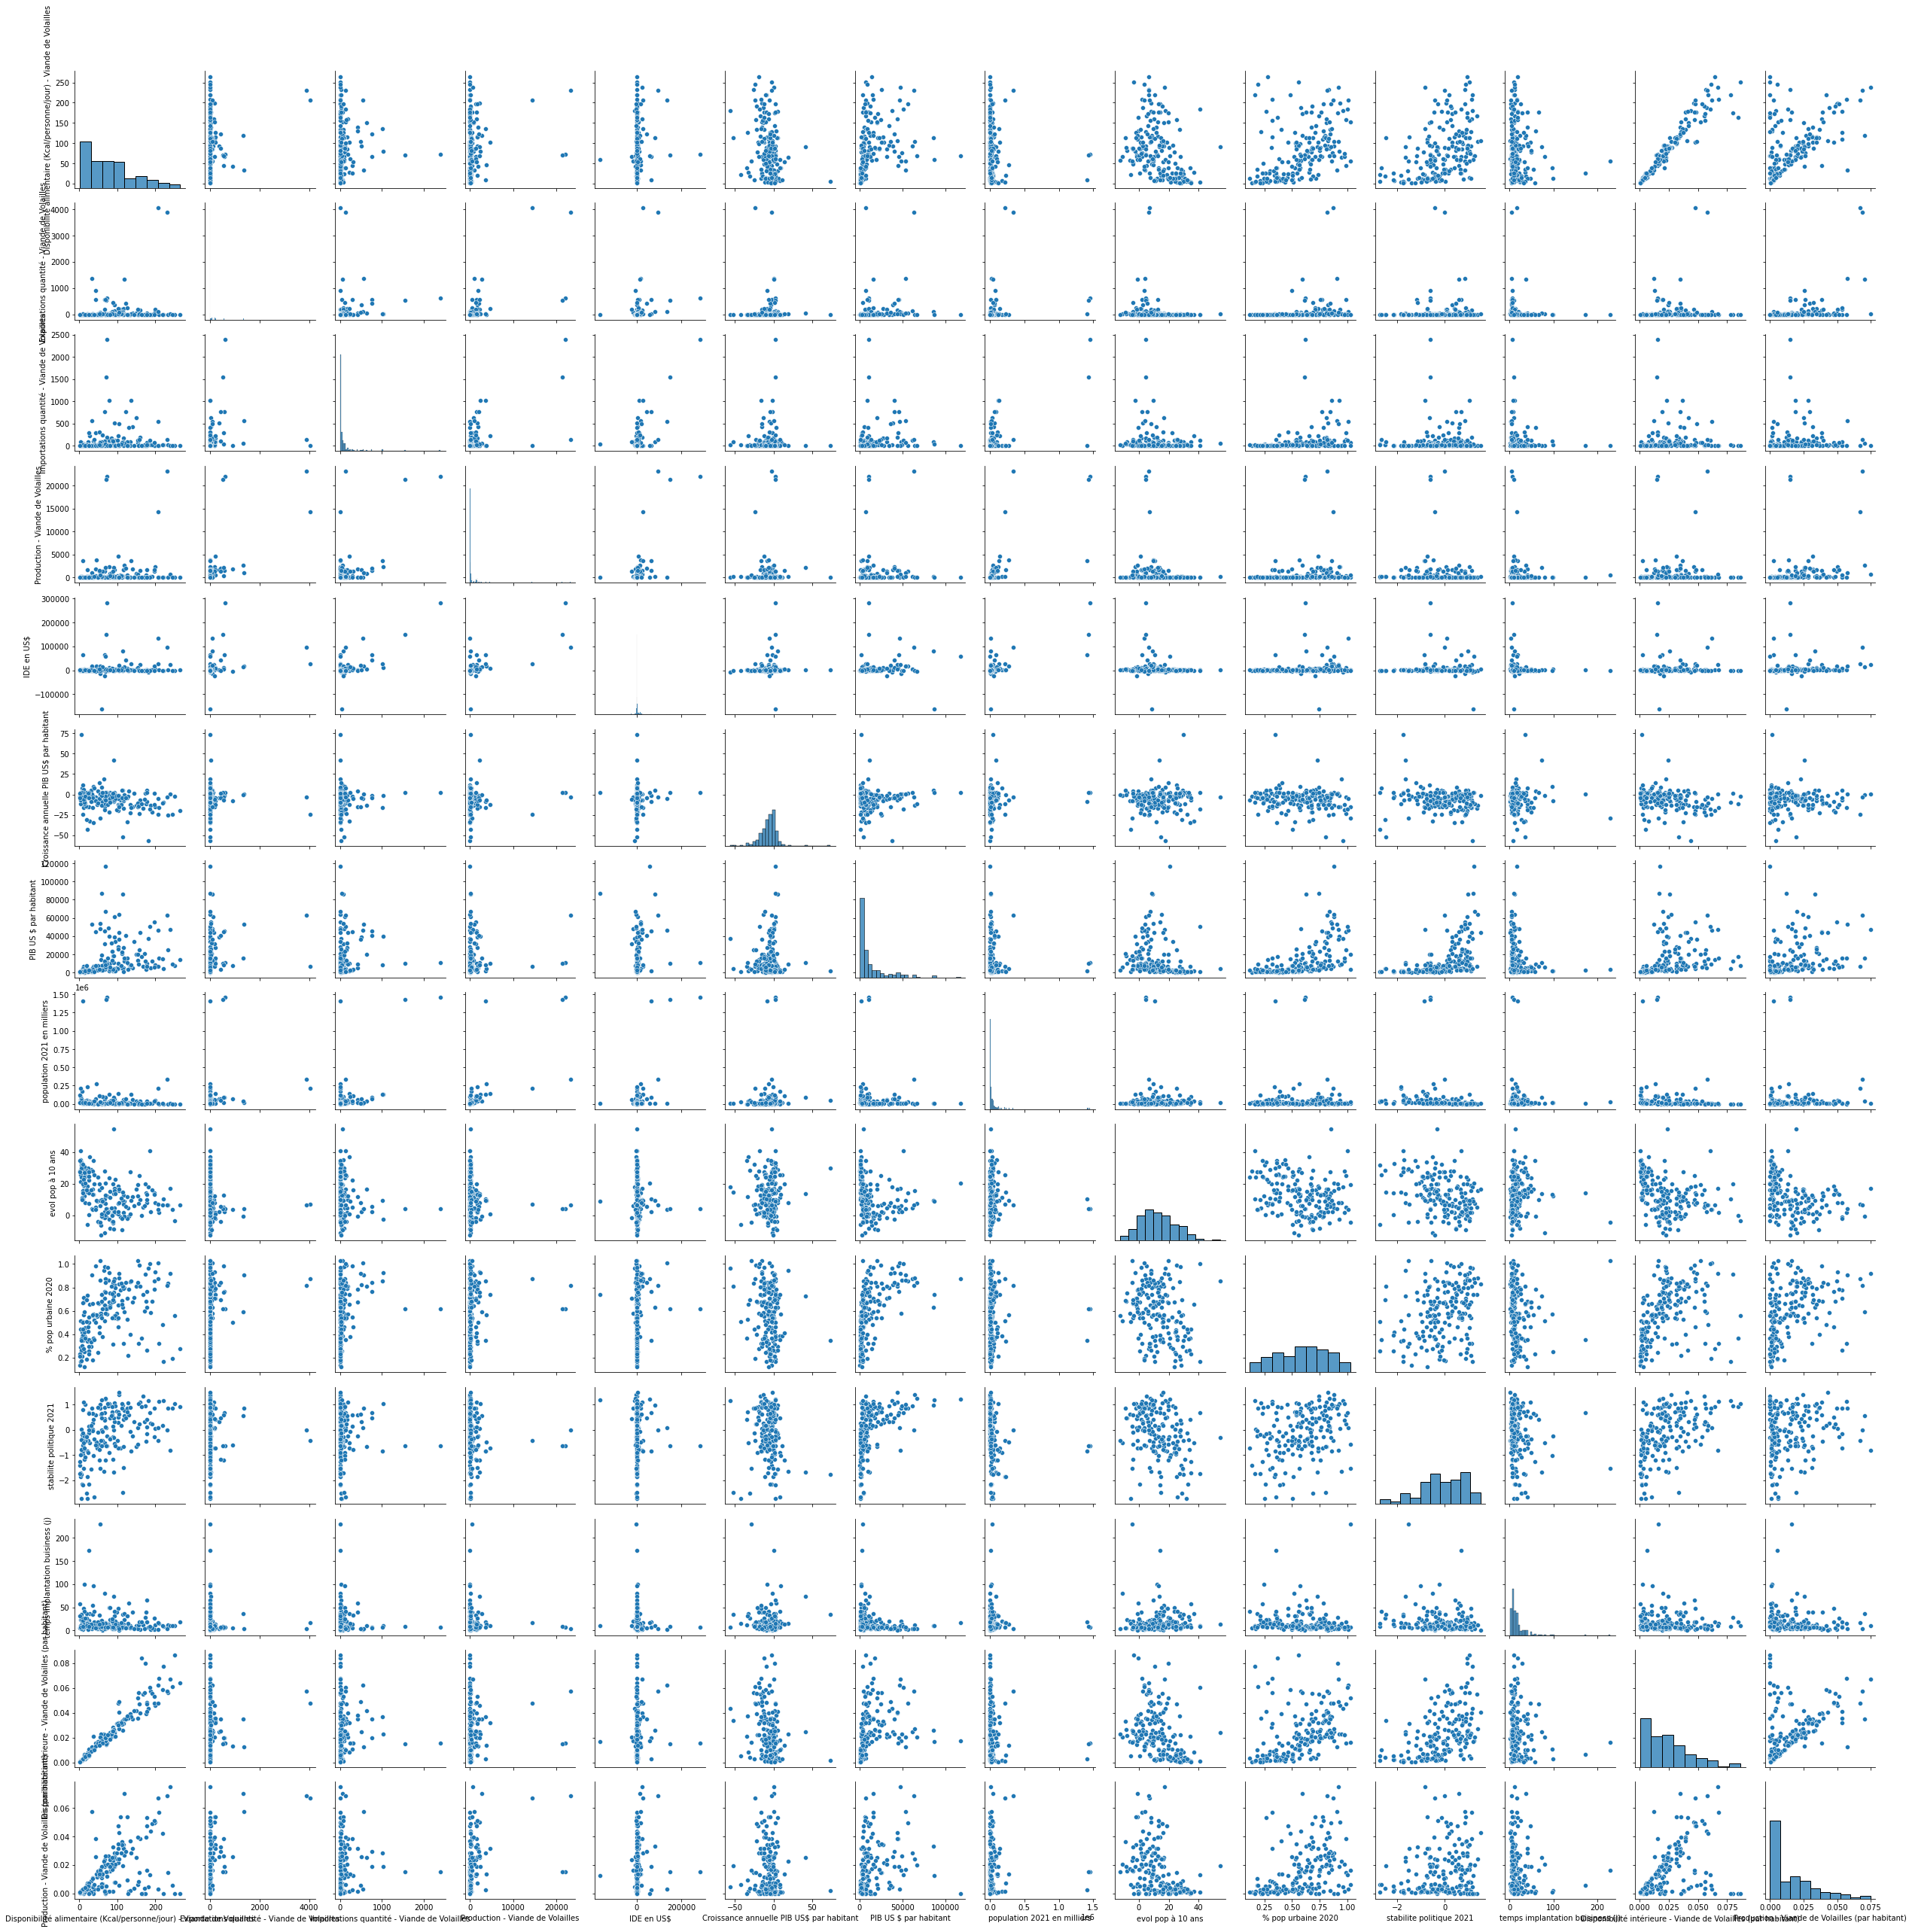

In [55]:
sns.pairplot(df_tableau_analyse)

<div class="alert alert-warning" role="alert"><b>
Attention : On remarque que la plupart des variables semblent suivre une distribution par loi de puissance (ex: <i>PIB US$ habitant</i>) comme c'est souvent le cas pour les variables économiques. Il est important de prendre en compte cette information par la suite lorsque nous procéderons au scaling de la donnée lors du setup des modèles statistiques de réduction des variables / clustering. 
On note aussi une importante influence de la taille de la population sur certaines variables, notamment pour la disponibilité et la production. Nous allons donc créer des variables pondérées pour pouvoir affiner notre analyse.
</b></div>

## Pondération des variables selon population et renaming de variables

In [52]:
#Etape 1 - Calculer les variables pondérées
df_tableau_analyse['Disponibilité intérieure - Viande de Volailles (par habitant)'] = df_tableau_analyse['Disponibilité intérieure - Viande de Volailles']/df_tableau_analyse['population 2021 en milliers']
df_tableau_analyse['Production - Viande de Volailles (par habitant)'] = df_tableau_analyse['Production - Viande de Volailles']/df_tableau_analyse['population 2021 en milliers']

#Etape 2 - Supprimer les variables non pondérées
df_tableau_analyse = df_tableau_analyse.drop(columns =['Disponibilité intérieure - Viande de Volailles'
    ])

#Etape 3 - Clean les noms des variables PIB
df_tableau_analyse = df_tableau_analyse.rename(columns = {"Valeur US $ par habitant": "PIB US $ par habitant", 
                                                          "Croissance annuelle US$ par habitant": "Croissance annuelle PIB US$ par habitant"}
                                              )


In [53]:
df_tableau_analyse

,Disponibilité alimentaire (Kcal/personne/jour) - Viande de Volailles,Exportations quantité - Viande de Volailles,Importations quantité - Viande de Volailles,Production - Viande de Volailles,IDE en US$,Croissance annuelle PIB US$ par habitant,PIB US $ par habitant,population 2021 en milliers,evol pop à 10 ans,% pop urbaine 2020,stabilite politique 2021,temps implantation buisiness (j),Disponibilité intérieure - Viande de Volailles (par habitant),Production - Viande de Volailles (par habitant)
Zone,,,,,,,,,,,,,,
Afghanistan,6.0,0.0,36.0,28.0,12.970148,2.316810,508.453722,40099.462,31.618301,0.254138,-2.73,9,0.001671,0.000698
Afrique du Sud,140.0,49.0,425.0,1881.0,3062.256423,-15.113259,5094.384038,59392.255,11.755044,0.672612,-0.24,40,0.034803,0.031671
Albanie,71.0,0.0,26.0,14.0,1069.861314,-3.080819,5180.914198,2854.710,-1.296006,0.637411,0.08,5,0.014012,0.004904
Algérie,22.0,1.0,0.0,284.0,1142.640689,-15.282432,3367.963003,44177.969,18.564953,0.735321,-0.86,18,0.006338,0.006429
Allemagne,67.0,575.0,766.0,1572.0,64589.266093,-1.393035,45908.724713,83408.554,2.284599,0.767204,0.67,8,0.019494,0.018847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Émirats arabes unis,104.0,86.0,493.0,51.0,19884.468665,-15.027324,36284.547906,9365.145,8.080537,0.919767,0.63,4,0.049012,0.005446
Équateur,81.0,0.0,0.0,333.0,1104.193903,-9.998056,5600.391520,17797.737,14.943629,0.632435,-0.36,49,0.018710,0.018710
États-Unis d'Amérique,231.0,3878.0,135.0,23150.0,95037.000000,-2.812720,63122.594145,336997.624,6.425460,0.815543,-0.02,4,0.057719,0.068695


## Export du df_tableau_analyse au format .csv servant de base pour le clustering, la visualisation et l'analyse

In [54]:
export_excel(df_tableau_analyse,'tableau_analyse.csv')

Le data_frame a été exporté au format excel.
